In [1]:
%load_ext autoreload
%autoreload 2

In [121]:
import os
import time
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

from src.plotting_utils import (
    get_instuction_following_percentage,
    get_last_exp_by_time,
    RANDOM_PERFORMANCE,
    DATASET_NAMES,
    LEVEL_COLORS,
    MODEL_NAMES,
)
from src.utils import load_pickle
from src.dataset_utils import get_dataset
from src.definitions import LEVELS
from src.arguments import get_advocate_data_folder
import matplotlib.patches as mpatches

data_path = "euler_logs/logs_17_03_v2/"
model_advocate = "Llama-2-70b-chat"
models = ["Llama-2-70b-chat", "Mixtral", "falcon-40b"]

model_colors = ["#293e9f", "#88abfd", "#df431d"]


datasets = [
    "piqa",
    "siqa",
    "commonsense_qa",
    "openbookqa",
    "wiki_qa",
    "gpqa",
    "quality",
    "boolq",
]

In [109]:
# First let us calculate the random performance for each dataset
CALCULATE_STATS = False

if CALCULATE_STATS:
    results = {}
    for dataset_name in datasets:
        dataset, choices, base_answer = get_dataset(
            Namespace(base_data_folder="./data"),
            dataset_name,
            None,
            system_prompt="",
            is_advocate=False,
            num_samples=None,
            advocate_level="None",
            advocate_file=None,
            include_explanation=False,
        )

        results[dataset_name] = np.mean(
            [
                len(dataset[i]["correct_answers_idx"])
                / (
                    len(dataset[i]["correct_answers_idx"])
                    + len(dataset[i]["wrong_answers_idx"])
                )
                for i in range(len(dataset))
            ]
        )

    print(results)

## First let us check the instruction following

In [110]:
results = []

for dataset_name in datasets:
    judge_level = "assistant"
    advocate_level = "assistant"

    for model in models:
        for include_explanation in [False, True]:
            # Load the data
            base_dir = os.path.join(data_path, model, dataset_name)
            exp = get_last_exp_by_time(os.listdir(base_dir))
            base_dir = os.path.join(base_dir, exp)

            prob_filename = f"probabilities_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            probabilities = load_pickle(os.path.join(base_dir, prob_filename))

            dataset_filanem = (
                f"dataset_{judge_level}_{advocate_level}_{include_explanation}.pkl"
            )
            dataset = load_pickle(os.path.join(base_dir, dataset_filanem))

            results.append(
                {
                    "dataset": dataset_name,
                    "model": model,
                    "include_explanation": include_explanation,
                    "instuction_following_percentage": get_instuction_following_percentage(
                        dataset, probabilities
                    ).mean(),
                }
            )

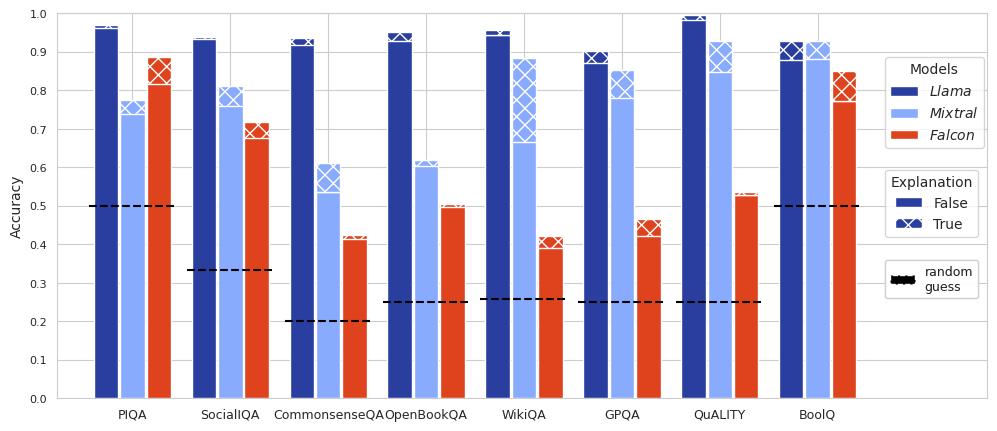

In [149]:
from src.plotting_utils import DATASET_NAMES

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

x_points = np.arange(len(datasets))
total_width = 0.75
spacing = 0.02
width = total_width / len(models)

for i, model in enumerate(models):
    y_points_False = np.array(
        [
            res["instuction_following_percentage"]
            for res in results
            if res["model"] == model and res["include_explanation"] == False
        ]
    )
    ax.bar(
        x_points + i * width + i * spacing,
        y_points_False,
        width=width,
        label=model,
        color=model_colors[i],
        zorder=5,
    )

    # plot on top of the bar
    y_points_True = np.array(
        [
            res["instuction_following_percentage"]
            for res in results
            if res["model"] == model and res["include_explanation"] == True
        ]
    )

    ax.bar(
        x_points + i * width + i * spacing,
        y_points_True - y_points_False,
        width=width,
        label=model,
        bottom=y_points_False,
        color=model_colors[i],
        hatch="XX",
        zorder=5,
    )

for i, dataset_name in enumerate(datasets):
    # plots random prediction like
    ax.plot(
        [i - width / 2 - 0.05, i + total_width - width / 2 + 0.08],
        [RANDOM_PERFORMANCE[dataset_name], RANDOM_PERFORMANCE[dataset_name]],
        color="black",
        linestyle="--",
        zorder=10,
    )

ax.set_xlim([-0.5, len(datasets) + 1])
ax.set_xticks(
    x_points + np.mean([i * (width + spacing) for i in range(len(models))]),
    [DATASET_NAMES[dataset_name] for dataset_name in datasets],
    rotation=0,
    fontsize=9,
)
ax.set_yticks(
    np.arange(0, 1.1, 0.1),
    ["{:.1f}".format(x) for x in np.arange(0, 1.1, 0.1)],
    fontsize=8,
)
ax.set_ylabel("Accuracy")

legend_lines = [mpatches.Patch(facecolor=color, alpha=1) for color in model_colors]
legend_names = [MODEL_NAMES[model] for model in models]
legend = plt.legend(
    legend_lines, legend_names, loc=(0.89, 0.65), ncol=1, fontsize=10, title="Models"
)
ax.add_artist(legend)

legend_lines = [
    mpatches.Patch(facecolor=model_colors[0], alpha=1, hatch=hatch)
    for hatch in [None, "XX"]
]
legend_names = ["False", "True"]
legend = plt.legend(
    legend_lines,
    legend_names,
    loc=(0.89, 0.42),
    ncol=1,
    fontsize=10,
    title="Explanation",
)
ax.add_artist(legend)

legend = plt.legend(
    [mpatches.Patch(facecolor="black", ls="--", alpha=1)],
    ["random\nguess"],
    loc=(0.89, 0.26),
    ncol=1,
    fontsize=9,
)
ax.add_artist(legend)
plt.savefig("figures/instuction_following_percentage.pdf")
plt.show()

In [119]:
plt.Bar()

AttributeError: module 'matplotlib.pyplot' has no attribute 'Bar'